In [14]:
%pip install -qU langchain-pinecone pinecone-client==3.1.0 langchain-core==0.3.6 openai==1.40.0


Note: you may need to restart the kernel to use updated packages.


In [1]:
from importlib.metadata import version
print(f"langchain-pinecone version: {version('langchain-pinecone')}")
print(f"pinecone version: {version('pinecone-client')}")
print(f"langchain core version: {version('langchain-core')}")

langchain-pinecone version: 0.2.0
pinecone version: 3.1.0
langchain core version: 0.3.6


In [2]:
%load_ext dotenv
%dotenv
%load_ext autoreload
%autoreload 2

In [3]:
import os
from pinecone import Pinecone
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore


# Scout settings
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
PINECONE_API_KEY = os.getenv('PINECONE_API_KEY')
LANGCHAIN_API_KEY = os.getenv('LANGCHAIN_API_KEY')

# LangSmith Tracing
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "scout-agent"

# Pinecone
pc = Pinecone(api_key=PINECONE_API_KEY)
index_name = "scout"
index = pc.Index(index_name)
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")  
vector_store = PineconeVectorStore(index=index, embedding=embeddings)


In [4]:
import datetime

def retrieve_pinecone(query: str) -> dict:
    """
    Retrieve relevant context and source from Pinecone
    - query: user's question
    - We filter out score < 0.8 to ensure the relevance of the context
    """
    context = []
    source = []
    added_urls = set()
    separator = "\n"
    vectorstore = vector_store

    # Find top-k relevant articles from Pinecone
    results = vectorstore.similarity_search_with_score(query, k=4)

    for res in results:
        x, score = res
        if score > 0.83:
            context.append(separator + x.page_content)
            metadata = {key: value.date().isoformat() if isinstance(value,
                                                                    datetime.datetime) else value
                        for key, value in x.metadata.items()
                        if key in ['item_source', 'item_title', 'item_url',
                                   'item_image_url', 'item_created_at']}
            # Check if we have the same source url
            if metadata['item_url'] not in added_urls:
                source.append(metadata)
                added_urls.add(metadata['item_url'])

    context = "".join(context)

 # Return structured data
    return {'answer': context, 'source': source}

In [5]:
import requests
from langchain_core.tools import tool

@tool
def search_trailforks(trail_name:str) -> dict:
    """
    Use this tool to get id for a specific trail or route based on input trail_name 
    """
    app_id = 76
    app_secret = '8c1cea65e4305c3f'

    url = f"https://www.trailforks.com/api/1/search?term={trail_name}&type=trail&scope=full&app_id={app_id}&app_secret={app_secret}"
    
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        #Extracting trail ID from the response
        if data:
            id = data['data']['hits']['hits'][0]['_id'] #return the top result out of 50
            #source = data['data']['hits']['hits'][0]['_source']
            return {'answer': f"Trail Map Preview", 'source': [id]}
        return {'answer': "No trail found", 'source': []}

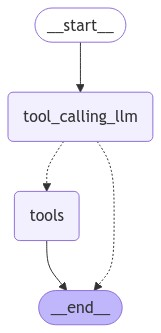

In [6]:
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

llm = ChatOpenAI(model="gpt-4o-mini")

llm_with_tools = llm.bind_tools([retrieve_pinecone, search_trailforks])

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([retrieve_pinecone, search_trailforks]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [108]:
from langchain_core.messages import HumanMessage

query1 = "What are the best running  shoes in 2024?"
query2 = "Tell me the id of Pacific Crest Trail"


messages = [HumanMessage(content=query1)]
messages = graph.invoke({"messages": messages})
last_msg = messages['messages'][-1]
#print(type(last_msg)) # 'langchain_core.messages.tool.ToolMessage'

# tool_message = messages['messages'][-1]
# 
# tool_message.content
for m in messages['messages']:
    m.pretty_print()

TypeError: 'HumanMessage' object is not subscriptable

# Agent

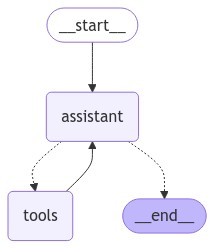

In [78]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# System message
sys_msg = SystemMessage(content="You are a outdoor activity expert tasked with recommending trails and answer questions about hiking, trail running and mountain biking.")

tools = [retrieve_pinecone, search_trailforks]

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [96]:
query1 = "What are the best running  shoes in 2024?"
query2 = "Tell me the id of Pacific Crest Trail"

messages = [HumanMessage(content=query1)]
messages = react_graph.invoke({"messages": messages})

In [102]:
messages

{'messages': [HumanMessage(content='What are the best running  shoes in 2024?', additional_kwargs={}, response_metadata={}, id='e7bffd89-2968-4294-8f46-f926337a6fc4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vpmZFcbW4WNJFyzOG6Rjdne1', 'function': {'arguments': '{"query":"best running shoes 2024"}', 'name': 'retrieve_pinecone'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 144, 'total_tokens': 165, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f85bea6784', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-50be8c79-9240-442a-a318-fe1cb77637f6-0', tool_calls=[{'name': 'retrieve_pinecone', 'args': {'query': 'best running shoes 2024'}, 'id': 'call_vpmZFcbW4WNJFyzOG6Rjdne1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 144, 'output_tokens': 21, 'total_t

In [97]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What are the best running  shoes in 2024?
================================== Ai Message ==================================
Tool Calls:
  retrieve_pinecone (call_vpmZFcbW4WNJFyzOG6Rjdne1)
 Call ID: call_vpmZFcbW4WNJFyzOG6Rjdne1
  Args:
    query: best running shoes 2024
================================= Tool Message =================================
Name: retrieve_pinecone

["\n4. 2023’s Crop of New Shoes Are Crazy Cushy\nBased on the sneak peeks I’ve seen, next year’s road running shoes will be cushier and more energetic than ever. While there will be another great crop of new racing shoes —including Nike’s Vaporfly Next% 3 ($250) and Mizuno’s Wave Rebellion Pro ($250)—the best models coming out in 2023 will be cushy, energetic training shoes. Take for example Saucony’s new Kinvara Pro ($180), a super-stacked dual-density midsole sandwiched around a curvy tear-drop carbon-fiber plate. It has an 8mm heel-t

In [75]:
for s in graph.stream({"messages": messages}):
    print(s.content, end="", flush=True)

ValueError: Message dict must contain 'role' and 'content' keys, got {'messages': [HumanMessage(content='Tell me the id of Pacific Crest Trail', additional_kwargs={}, response_metadata={}, id='a8fc2942-173a-4c8d-908e-9a6a1c32c200'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fX3O3HhlehDRg90Wx4FgAJhH', 'function': {'arguments': '{"trail_name":"Pacific Crest Trail"}', 'name': 'search_trailforks'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 118, 'total_tokens': 138, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f85bea6784', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b6c66327-a494-44ff-b018-d9a6fd3fd252-0', tool_calls=[{'name': 'search_trailforks', 'args': {'trail_name': 'Pacific Crest Trail'}, 'id': 'call_fX3O3HhlehDRg90Wx4FgAJhH', 'type': 'tool_call'}], usage_metadata={'input_tokens': 118, 'output_tokens': 20, 'total_tokens': 138}), ToolMessage(content='trail-595523', name='search_trailforks', id='89ec8dda-1ce7-486a-b1a6-e28ded619ace', tool_call_id='call_fX3O3HhlehDRg90Wx4FgAJhH')]}